# SMS Spam Classification using Deep Learning

### Siraj Ali

Dataset location: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

In [52]:
from nltk import stem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd

In [3]:
SEED = 42
NLTK_DATA_PATH = ''
SPAM_DATA_PATH = './data/sms.txt'

In [2]:
if not os.path.exists(NLTK_DATA_PATH):
    nltk.download()
else:
    print('NLTK data already exists at specified path.')

NLTK data already exists at specified path.


## Read in the data

In [4]:
if os.path.exists(SPAM_DATA_PATH):
    df = pd.read_csv(SPAM_DATA_PATH, delimiter='\t', header=None, names=['label', 'raw'])
else:
    print(f'The data does not exist at path {DATA_PATH}')

In [5]:
df.head()

,label,raw
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# check for nulls
df.isna().sum()

label    0
raw      0
dtype: int64

### Check the distribution of spam and ham

There is about a 13.4% event rate that messages are spam in this dataset.

In [7]:
df.groupby(['label']).count() / df.shape[0]

,raw
label,
ham,0.865937
spam,0.134063


<AxesSubplot:>

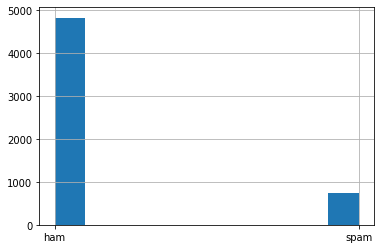

In [8]:
df['label'].hist()

### Check length of messages

Spam messages tend to be much longer than ham messages.

In [11]:
df.loc[:, 'length'] = df['raw'].apply(lambda x: len(x))

<AxesSubplot:>

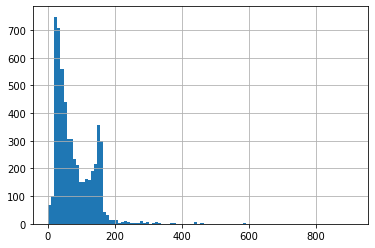

In [13]:
df['length'].hist(bins=100)

<AxesSubplot:>

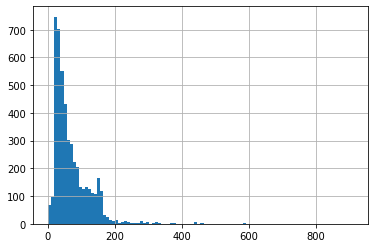

In [18]:
df.query('label == "ham"')['length'].hist(bins=100)

<AxesSubplot:>

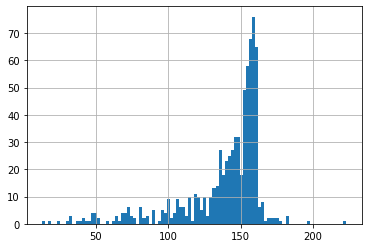

In [17]:
df.query('label == "spam"')['length'].hist(bins=100)

In [19]:
df.groupby('label')['length'].mean()

label
ham      71.482487
spam    138.670683
Name: length, dtype: float64

## Clean the text data

In [20]:
# binarize the target
df['target'] = df['label'].map({'ham': 0, 'spam': 1})

TODO:

In [21]:
stemmer = stem.SnowballStemmer('english') # Porter2 stemmer
stops = set(stopwords.words())

In [22]:
def process_messages(msg):
    
    # strip whitecase and case-normalize
    msg = msg.lower().strip()
    
    # tokenize word
    words = nltk.word_tokenize(msg)
    
    # remove punctuation
    words = [w for w in words if w.isalnum()]
    
    # remove stopwords
    words = [w for w in words if w not in stops]
    
    # use stemmer to get word stem
    final = ' '.join([stemmer.stem(w) for w in words])
    
    # return 
    return final

df['message'] = df['raw'].apply(process_messages)

In [23]:
dict(df.iloc[0])

{'label': 'ham',
 'raw': 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'length': 111,
 'target': 0,
 'message': 'go jurong point crazi avail bugi great world buffet got amor'}

## Train-Test Split

In [24]:
# stratified split to get equal distribution of event rate - 70/30 split for train and test
stratsplit = StratifiedShuffleSplit(test_size=0.3, random_state=SEED)

for train_idx, test_idx in stratsplit.split(df, df["target"]):
    df_train = df.iloc[train_idx]
    df_test = df.iloc[test_idx]

In [25]:
df_train['target'].value_counts()

0    3377
1     523
Name: target, dtype: int64

In [26]:
df_test['target'].value_counts()

0    1448
1     224
Name: target, dtype: int64

In [27]:
X_train = df_train.drop('target', axis=1)['message'].values
y_train = df_train['target'].values

In [28]:
X_test = df_test.drop('target', axis=1)['message'].values
y_test = df_test['target'].values

## Vectorize the text using Term Frequency - Inverse Document Frequency (TF-IDF)

In [29]:
vectorizer = TfidfVectorizer()

In [30]:
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Naive Bayes Classifier

In [41]:
bayes = MultinomialNB()
bayes.fit(X_train_vec, y_train)

MultinomialNB()

In [43]:
nb_preds = bayes.predict(X_test_vec)
accuracy_score(y_test, nb_preds)

0.9557416267942583

In [44]:
cf_mtrx = confusion_matrix(y_test, nb_preds)
print('TP:', cf_mtrx[0][0])
print('FP:', cf_mtrx[0][1])
print('FN:', cf_mtrx[1][0])
print('TN:', cf_mtrx[1][1])

TP: 1447
FP: 1
FN: 73
TN: 151


## SVM

In [32]:
svm = SVC(C=1.0, kernel='rbf')
svm.fit(X_train_vec, y_train)

SVC()

In [34]:
preds = svm.predict(X_test_vec)

In [35]:
accuracy_score(y_test, preds)

0.972488038277512

In [36]:
cf_mtrx = confusion_matrix(y_test, preds)
print('TP:', cf_mtrx[0][0])
print('FP:', cf_mtrx[0][1])
print('FN:', cf_mtrx[1][0])
print('TN:', cf_mtrx[1][1])

TP: 1447
FP: 1
FN: 45
TN: 179


While better than the Naive Bayes Classifier, the SVM produces a decent rate of false negatives! That's a good number of spam messages getting through.

## Recurrent Neural Network

In [60]:
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset

import torch
import torch.nn.functional as F

In [61]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeroes(1, self.hidden_size)

In [62]:
model = RNN(input_size=X_train.shape[0], hidden_size=100, output_size=2)

In [63]:
criterion = nn.NLLLoss()